<a href="https://colab.research.google.com/github/panagiotakf/Predicting-Fuel-Consumption-in-Shipping-by-Using-ML/blob/main/LSTM_for_simpler_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from time import time
from sklearn.neighbors import NearestCentroid
import pickle
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import log_loss, r2_score,mean_squared_error,accuracy_score,confusion_matrix,roc_curve
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import seaborn as sns
from keras import optimizers

In [ ]:
NUM_OF_HIDDEN_LAYERS = 3
NEURON_MULTIPLIER = 10
LR = [0.1, 0.01, 0.001, 0.0001, 0.00001]

In [ ]:
# Importing the dataset
dataset = pd.read_csv('MCS_dataset_W=3_C=2.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
print(X)
print('y: ',y)
#OUTPUT_L = np.zeros((len(LR), NUM_OF_HIDDEN_LAYERS))

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [100 100 100 ...  12  12  12]
 [100 100 100 ...  12  12  12]
 [100 100 100 ...  12  12  12]]
y:  [0 0 0 ... 1 1 1]


In [ ]:
# training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=12100, random_state=0)

In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
count=0
for i in y_test:
    #print(i)
    if(i==1):
        count=count+1
print(count)

156380
156380
12100
12100
6004


In [ ]:
#MinMaxScaling
#only for input, because we have classification
scaler_data=MinMaxScaler()

X_train=scaler_data.fit_transform(X_train)
X_test=scaler_data.transform(X_test)
print(X_test)

[[0.   0.   0.03 ... 0.   0.   0.  ]
 [1.   1.   1.   ... 0.25 0.25 0.25]
 [1.   1.   1.   ... 0.2  0.2  0.2 ]
 ...
 [1.   1.   1.   ... 0.6  0.6  0.6 ]
 [1.   1.   1.   ... 0.65 0.65 0.65]
 [1.   1.   1.   ... 0.4  0.4  0.4 ]]


In [ ]:
trainX=X_train.reshape(X_train.shape[0],3,3)
print(trainX.shape)

(156380, 3, 3)


In [ ]:
#πάμε να φτιάξουμε την δομή του lSTM
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2)) #για να εμποδίσει το overfitting.
model.add(Dense(1, activation='sigmoid')) #sigmoid is important for classication

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_33 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
8797/8797 [==============================] - 155s 16ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 2/3
8797/8797 [==============================] - 149s 17ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 3/3
8797/8797 [==============================] - 154s 18ms/step - loss: 0.0013 - val_loss: 0.0012


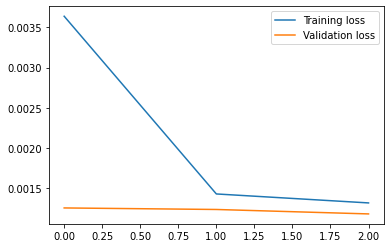

In [ ]:
history = model.fit(trainX, y_train, epochs=3, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
#predict
testX=X_test.reshape(X_test.shape[0],3,3)
prediction = model.predict(testX)

379/379 [==============================] - 5s 8ms/step


In [ ]:
print(y_test)
prediction=np.round(prediction)
for i in range(len(prediction)):
    prediction[i]=int(prediction[i])
print(prediction)

[0 1 1 ... 1 1 1]
[[0.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [ ]:
#Accuracy
print(accuracy_score(y_test,prediction))
dbfile = open('Test_set_for_W=3_C=2', 'wb')
pickle.dump(y_test,dbfile )
dbfile.close()
dbfile = open('Predictions_for_W=3_C=2', 'wb')
pickle.dump(prediction,dbfile )
dbfile.close()


0.9983471074380166


Text(0.5, 1.0, 'Confusion Matrix')

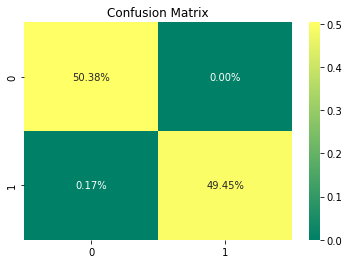

In [ ]:
#confusion matrix
cf_matrix = confusion_matrix(y_test,prediction)
#print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='summer')
plt.title('Confusion Matrix')

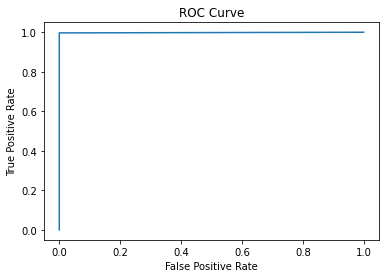

In [ ]:
#ROC Curve
fpr, tpr, _ = roc_curve(y_test,  prediction)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
def LSTM_train(trainX,y_train,X_test,y_test,lr,W):
    #πάμε να φτιάξουμε την δομή του lSTM
    model = Sequential()
    model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2)) #για να εμποδίσει το overfitting.
    model.add(Dense(1, activation='sigmoid')) #sigmoid is important for classication

    opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse')
    model.summary()
    #train
    history = model.fit(trainX, y_train, epochs=3, batch_size=16, validation_split=0.1, verbose=1)
    #predict
    testX=X_test.reshape(X_test.shape[0],W,3)
    prediction = model.predict(testX)
    prediction=np.round(prediction)
    for i in range(len(prediction)):
        prediction[i]=int(prediction[i])
    return accuracy_score(y_test,prediction)

In [ ]:
#για να βρούμε το καλύτερο learning rate
acc_for_lr=[]
for lr in list(map(lambda x:10**x, range(-5,0))):
    acc_for_lr.append(LSTM_train(trainX,y_train,X_test,y_test,lr,2))
    print(acc_for_lr)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 6, 64)             17408     
                                                                 
 lstm_39 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
27022/27022 [==============================] - 828s 30ms/step - loss: 0.0196 - val_loss: 0.0019
Epoch 2/3
27022/27022 [==============================] - 840s 31ms/step - l

In [ ]:
plt.plot((list(map(lambda x:10**x, range(-5,0)))), acc_for_lr,marker='.')
plt.xscale('log')
plt.ylabel('Accuracy', size=15)
plt.xlabel('Learning Rate', size=15)
plot.title('Accuracy vs Learning Rate')
plt.show()

In [ ]:
def LSTM_train_hidden_layers(trainX,y_train,X_test,y_test,hl,W):
    #πάμε να φτιάξουμε την δομή του lSTM
    model = Sequential()
    if(hl==1):
        model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
    if(hl>1):
        model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
        for i in range(hl-2):
            model.add(LSTM(32, return_sequences=True))
        model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2)) #για να εμποδίσει το overfitting.
    model.add(Dense(1, activation='sigmoid')) #sigmoid is important for classication

    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')
    model.summary()
    #train
    history = model.fit(trainX, y_train, epochs=3, batch_size=16, validation_split=0.1, verbose=1)
    #predict
    testX=X_test.reshape(X_test.shape[0],W,3)
    prediction = model.predict(testX)
    prediction=np.round(prediction)
    for i in range(len(prediction)):
        prediction[i]=int(prediction[i])
    return accuracy_score(y_test,prediction)

In [ ]:
#για να βρούμε τον καλύτερο αριθμό hidden layer
acc_for_hl=[]
for hl in range(1,6):
    acc_for_hl.append(LSTM_train_hidden_layers(trainX,y_train,X_test,y_test,hl,W))
    print(acc_for_hl)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 64)                17408     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
8797/8797 [==============================] - 96s 10ms/step - loss: 0.0045 - val_loss: 0.0013
Epoch 2/3
8797/8797 [==============================] - 94s 11ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/3
379/379 [==============================] - 4s 7ms/step
[0.9983471074380166]
Model: "sequential_16

In [ ]:
plt.plot([1,2,3,4,5], acc_for_hl,marker='.')
plt.ylabel('Accuracy', size=15)
plt.xlabel('Number of Hidden Layers', size=15)
plt.show()

### MCS dataset , W=6

In [ ]:
# Importing the dataset
dataset = pd.read_csv('MCS_dataset_W=6_C=2.txt')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
print(X)
print('y: ',y)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
y:  [0 0 0 ... 0 0 0]


In [ ]:
print(y[200])

1


In [ ]:
# training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=12100, random_state=0)

In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
count=0
for i in y_test:
    #print(i)
    if(i==1):
        count=count+1
print(count)

480380
480380
12100
12100
2065


In [ ]:
#MinMaxScaling
#only for input, because we have classification
scaler_data=MinMaxScaler()

X_train=scaler_data.fit_transform(X_train)
X_test=scaler_data.transform(X_test)
print(X_test)

[[0.   0.   0.   ... 0.   0.   0.  ]
 [1.   1.   1.   ... 0.2  0.2  0.2 ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.97 1.   1.   ... 0.8  0.8  0.8 ]]


In [ ]:
trainX=X_train.reshape(X_train.shape[0],6,3)
print(trainX.shape)

(480380, 6, 3)


In [ ]:
#πάμε να φτιάξουμε την δομή του lSTM
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2)) #για να εμποδίσει το overfitting.
model.add(Dense(1, activation='sigmoid')) #sigmoid is important for classication

#opt = optimizers.Adam(learning_rate=lr)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 6, 64)             17408     
                                                                 
 lstm_35 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
27022/27022 [==============================] - 927s 33ms/step - loss: 0.0011 - val_loss: 4.7826e-04
Epoch 2/3
27022/27022 [==============================] - 627s 23ms/step - loss: 5.3313e-04 - val_loss: 4.5423e-04
Epoch 3/3
27022/27022 [==============================] - 620s 23ms/step - loss: 4.8680e-04 - val_loss: 3.6625e-04


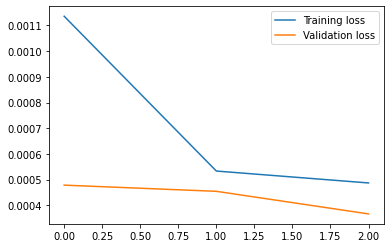

In [ ]:
history = model.fit(trainX, y_train, epochs=3, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
#predict
testX=X_test.reshape(X_test.shape[0],6,3)
prediction = model.predict(testX)

379/379 [==============================] - 6s 8ms/step


In [ ]:
print(y_test)
prediction=np.round(prediction)
for i in range(len(prediction)):
    prediction[i]=int(prediction[i])
print(prediction)

[0 1 0 ... 0 0 1]
[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]]


In [ ]:
#Accuracy
print(accuracy_score(y_test,prediction))
dbfile = open('Test_set_for_W=6_C=2', 'wb')
pickle.dump(y_test,dbfile )
dbfile.close()
dbfile = open('Predictions_for_W=6_C=2', 'wb')
pickle.dump(prediction,dbfile )
dbfile.close()

0.9993388429752066


Text(0.5, 1.0, 'Confusion Matrix')

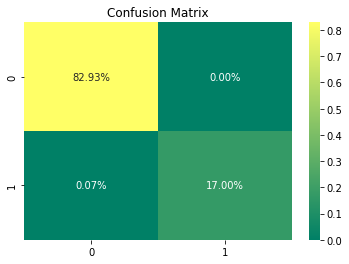

In [ ]:
#confusion matrix
#different numbers becsuse of different train test split
cf_matrix = confusion_matrix(y_test,prediction)
#print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='summer')
plt.title('Confusion Matrix')

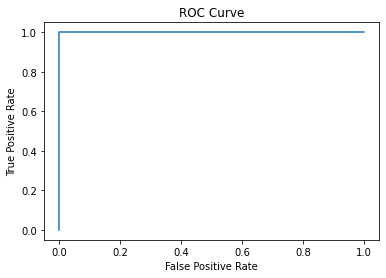

In [ ]:
#ROC Curve
fpr, tpr, _ = roc_curve(y_test,  prediction)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
#για να βρούμε το καλύτερο learning rate
acc_for_lr=[]
for lr in list(map(lambda x:10**x, range(-5,0))):
    acc_for_lr.append(LSTM_train(trainX,y_train,X_test,y_test,lr,6))
    print(acc_for_lr)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 6, 64)             17408     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
27022/27022 [==============================] - 562s 20ms/step - loss: 0.0195 - val_loss: 0.0019
Epoch 2/3
27022/27022 [==============================] - 423s 16ms/step - lo

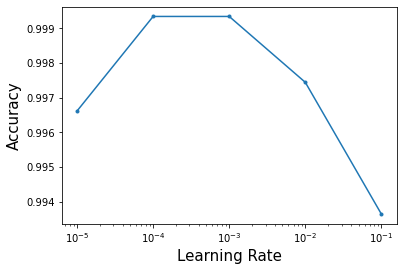

In [ ]:
plt.plot((list(map(lambda x:10**x, range(-5,0)))), acc_for_lr,marker='.')
plt.xscale('log')
plt.ylabel('Accuracy', size=15)
plt.xlabel('Learning Rate', size=15)
plt.show()

In [ ]:
#για να βρούμε τον καλύτερο αριθμό hidden layer
acc_for_hl=[]
for hl in range(1,6):
    acc_for_hl.append(LSTM_train_hidden_layers(trainX,y_train,X_test,y_test,hl,6))
    print(acc_for_hl)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 64)                17408     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
27022/27022 [==============================] - 261s 9ms/step - loss: 0.0013 - val_loss: 4.8448e-04
Epoch 2/3
27022/27022 [==============================] - 260s 10ms/step - loss: 5.2478e-04 - val_loss: 4.4727e-04
Epoch 3/3
379/379 [==============================] - 3s 5ms/step
[0.9993388429752066]
Model

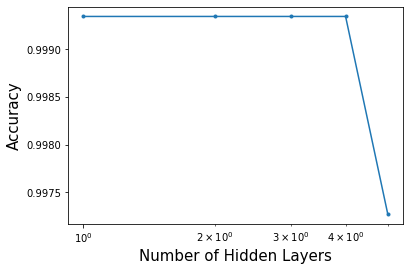

In [ ]:
plt.plot([1,2,3,4,5], acc_for_hl,marker='.')
plt.ylabel('Accuracy', size=15)
plt.xlabel('Number of Hidden Layers', size=15)
plt.show()

### MCS dataset, W=9

In [ ]:
# Importing the dataset
dataset = pd.read_csv('MCS_dataset_W=9_C=2.txt')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
print(X)
print('y: ',y)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
y:  [0 0 0 ... 0 0 0]


In [ ]:
print(len(X[:]))

479520


In [ ]:
# training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=12100, random_state=0)

In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
count=0
for i in y_test:
    #print(i)
    if(i==1):
        count=count+1
print(count)

467420
467420
12100
12100
2239


In [ ]:
#MinMaxScaling
#only for input, because we have classification
scaler_data=MinMaxScaler()

X_train=scaler_data.fit_transform(X_train)
X_test=scaler_data.transform(X_test)
print(X_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
trainX=X_train.reshape(X_train.shape[0],9,3)
print(trainX.shape)

(467420, 9, 3)


In [ ]:
#πάμε να φτιάξουμε την δομή του lSTM
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2)) #για να εμποδίσει το overfitting.
model.add(Dense(1, activation='sigmoid')) #sigmoid is important for classication

#opt = optimizers.Adam(learning_rate=lr)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 9, 64)             17408     
                                                                 
 lstm_32 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
26293/26293 [==============================] - 866s 32ms/step - loss: 0.0011 - val_loss: 4.2810e-04
Epoch 2/3
26293/26293 [==============================] - 678s 26ms/step - loss: 5.3359e-04 - val_loss: 3.8126e-04
Epoch 3/3
26293/26293 [==============================] - 655s 25ms/step - loss: 6.2686e-04 - val_loss: 3.6055e-04


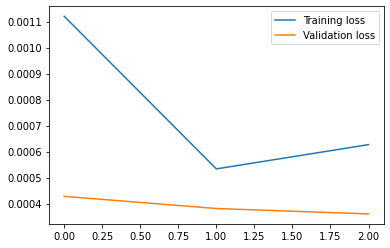

In [ ]:
history = model.fit(trainX, y_train, epochs=3, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
#predict
testX=X_test.reshape(X_test.shape[0],9,3)
prediction = model.predict(testX)

379/379 [==============================] - 6s 10ms/step


In [ ]:
print(y_test)
prediction=np.round(prediction)
for i in range(len(prediction)):
    prediction[i]=int(prediction[i])
print(prediction)

[0 0 1 ... 0 0 0]
[[0.]
 [0.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


In [ ]:
#Accuracy
print(accuracy_score(y_test,prediction))
dbfile = open('Test_set_for_W=9_C=2', 'wb')
pickle.dump(y_test,dbfile )
dbfile.close()
dbfile = open('Predictions_for_W=9_C=2', 'wb')
pickle.dump(prediction,dbfile )
dbfile.close()

0.9993388429752066


<AxesSubplot: >

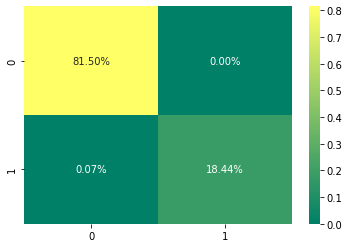

In [ ]:
#confusion matrix
#different numbers becsuse of different train test split
cf_matrix = confusion_matrix(y_test,prediction)
#print(cf_matrix)
plt.title('Confusion Matrix')
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='summer')

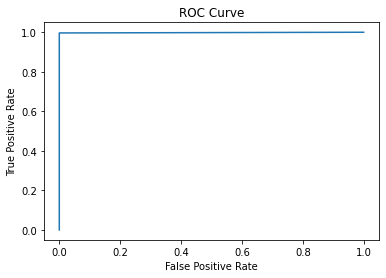

In [ ]:
#ROC Curve
fpr, tpr, _ = roc_curve(y_test,  prediction)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
#για να βρούμε το καλύτερο learning rate
acc_for_lr=[]
for lr in list(map(lambda x:10**x, range(-5,0))):
    acc_for_lr.append(LSTM_train(trainX,y_train,X_test,y_test,lr,9))
    print(acc_for_lr)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 9, 64)             17408     
                                                                 
 lstm_34 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
26293/26293 [==============================] - 614s 23ms/step - loss: 0.0147 - val_loss: 0.0017
Epoch 2/3
26293/26293 [==============================] - 602s 23ms/step - l

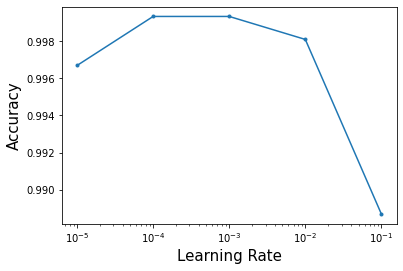

In [ ]:
plt.plot((list(map(lambda x:10**x, range(-5,0)))), acc_for_lr,marker='.')
plt.xscale('log')
plt.ylabel('Accuracy', size=15)
plt.xlabel('Learning Rate', size=15)
plt.show()

In [ ]:
#για να βρούμε τον καλύτερο αριθμό hidden layer
acc_for_hl=[]
for hl in range(1,6):
    acc_for_hl.append(LSTM_train_hidden_layers(trainX,y_train,X_test,y_test,hl,9))
    print(acc_for_hl)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 64)                17408     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
26293/26293 [==============================] - 401s 15ms/step - loss: 0.0012 - val_loss: 4.2900e-04
Epoch 2/3
26293/26293 [==============================] - 409s 16ms/step - loss: 5.3260e-04 - val_loss: 4.2998e-04
Epoch 3/3
379/379 [==============================] - 8s 16ms/step
[0.9993388429752066]
Mo

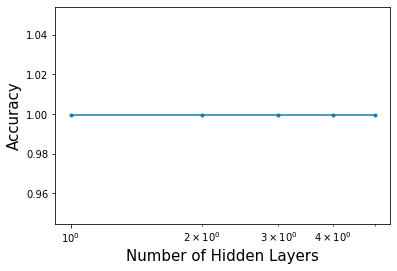

In [ ]:
plt.plot([1,2,3,4,5], acc_for_hl,marker='.')
plt.xscale('log')
plt.ylabel('Accuracy', size=15)
plt.xlabel('Number of Hidden Layers', size=15)
plt.show()

### Prediction for further in the future

Όπως είδαμε, η ακρίβεια (accuracy) επηρεάζεται από το χρονικό παράθυρο, ωστόσο σε όλα τα χρονικά παράθυρα πετυχαίναμε πολύ υψηλό accuracy, οπότε θα επιλέξουμε το W=3, προκειμένου να περιορίσουμε τον αριθμό εισόδων στο μοντέλο μας. Για W=3, ο αριθμός των hidden layers δεν επηρεάζει την απόδοση μας, οπότε θα επιλέξουμε να έχουμε ένα μόνο hidden layer για να απλουστεύσουμε το μοντέλο μας, ενώ, ως βέλτιστο lr επιλέγουμε το 10^(-3).

In [ ]:
C=10

In [ ]:
# Importing the dataset
dataset = pd.read_csv('MCS_dataset_W=3_C='+str(C)+'.txt')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
print(X)
print('y: ',y)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
y:  [0 0 0 ... 0 0 0]


In [ ]:
# training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=12100, random_state=0)

In [ ]:
#MinMaxScaling
#only for input, because we have classification
scaler_data=MinMaxScaler()

X_train=scaler_data.fit_transform(X_train)
X_test=scaler_data.transform(X_test)
print(X_test)

[[1.  1.  1.  ... 0.8 0.8 0.8]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [1.  1.  1.  ... 0.2 0.2 0.2]]


In [ ]:
trainX=X_train.reshape(X_train.shape[0],3,3)
print(trainX.shape)

(458780, 3, 3)


In [ ]:
#πάμε να φτιάξουμε την δομή του lSTM
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
model.add(Dropout(0.2)) #για να εμποδίσει το overfitting.
model.add(Dense(1, activation='sigmoid')) #sigmoid is important for classication

#opt = optimizers.Adam(learning_rate=lr)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 64)                17408     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
25807/25807 [==============================] - 580s 21ms/step - loss: 0.0101 - val_loss: 0.0094
Epoch 2/3
25807/25807 [==============================] - 357s 14ms/step - loss: 0.0084 - val_loss: 0.0078
Epoch 3/3
25807/25807 [==============================] - 374s 15ms/step - loss: 0.0082 - val_loss: 0.0088


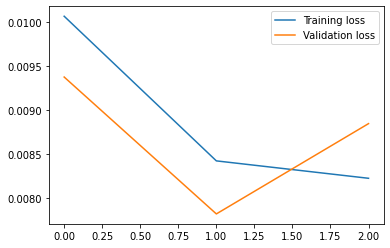

In [ ]:
history = model.fit(trainX, y_train, epochs=3, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
#predict
testX=X_test.reshape(X_test.shape[0],3,3)
prediction = model.predict(testX)

379/379 [==============================] - 6s 8ms/step


In [ ]:
print(y_test)
prediction=np.round(prediction)
for i in range(len(prediction)):
    prediction[i]=int(prediction[i])
print(prediction)

[1 0 0 ... 0 0 1]
[[1.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]]


In [ ]:
#Accuracy
print(accuracy_score(y_test,prediction))

0.989504132231405


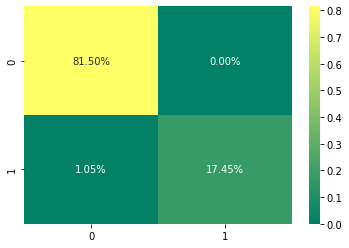

In [ ]:
#confusion matrix
#different numbers becsuse of different train test split
cf_matrix = confusion_matrix(y_test,prediction)
#print(cf_matrix)
svm=sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='summer')
plt.title('Confusion Matrix')
figure = svm.get_figure()
figure.savefig('Confusion_Matrxi_C='+str(C)+'.png', dpi=400)

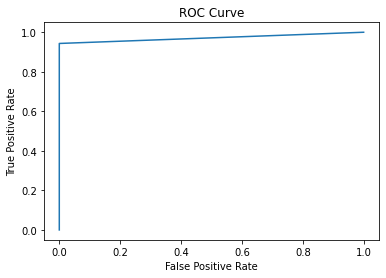

In [ ]:
#ROC Curve
fpr, tpr, _ = roc_curve(y_test,  prediction)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.savefig('ROC_Curve_C='+str(C)+'.png')
plt.show()

In [ ]:
#για να βρούμε το καλύτερο learning rate
acc_for_lr=[]
for lr in list(map(lambda x:10**x, range(-5,0))):
    acc_for_lr.append(LSTM_train(trainX,y_train,X_test,y_test,lr,3))
    print(acc_for_lr)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 3, 64)             17408     
                                                                 
 lstm_30 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
25807/25807 [==============================] - 759s 28ms/step - loss: 0.0113 - val_loss: 0.0079
Epoch 2/3
25807/25807 [==============================] - 742s 29ms/step - l

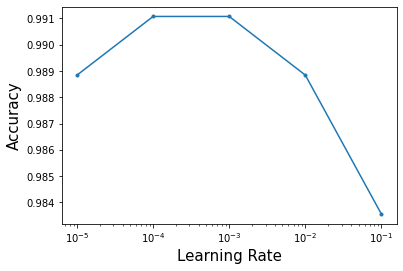

In [ ]:
plt.plot((list(map(lambda x:10**x, range(-5,0)))), acc_for_lr,marker='.')
plt.xscale('log')
plt.ylabel('Accuracy', size=15)
plt.xlabel('Learning Rate', size=15)
plt.savefig('Learning_Rate_C='+str(C)+'.png')
plt.show()

In [ ]:
#για να βρούμε τον καλύτερο αριθμό hidden layer
acc_for_hl=[]
for hl in range(1,6):
    acc_for_hl.append(LSTM_train_hidden_layers(trainX,y_train,X_test,y_test,hl,3))
    print(acc_for_hl)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 64)                17408     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
25807/25807 [==============================] - 211s 8ms/step - loss: 0.0094 - val_loss: 0.0078
Epoch 2/3
25807/25807 [==============================] - 207s 8ms/step - loss: 0.0085 - val_loss: 0.0078
Epoch 3/3
379/379 [==============================] - 3s 6ms/step
[0.9910743801652893]
Model: "sequential

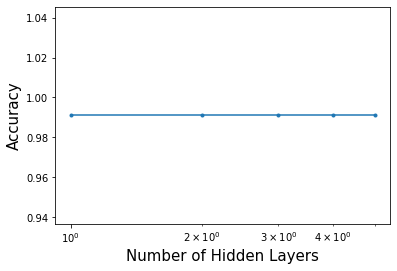

In [ ]:
plt.plot([1,2,3,4,5], acc_for_hl,marker='.')
plt.xscale('log')
plt.ylabel('Accuracy', size=15)
plt.xlabel('Number of Hidden Layers', size=15)
plt.savefig('Number_Hidden_Layers_C='+str(C)+'.png')
plt.show()